In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import GunshotDataset
import gunshot_utils as utils
import importlib
import torch as th
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import librosa
import ast
import pickle
import re
import soundfile as sf
from pydub.playback import play
import os
import numpy as np
import torchaudio
import GunshotModel
import GunshotDetection
from torch.optim import Adam
import torch.nn as nn

importlib.reload(utils)
importlib.reload(GunshotDetection)
importlib.reload(GunshotDataset)
importlib.reload(GunshotModel)

/Users/abelboros/.pyenv/versions/thesis_env/lib/python3.9/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


<module 'GunshotModel' from '/Users/abelboros/Documents/Personal/Code/PopMusicInformationRetrieval/GunshotModel.py'>

In [31]:
# with open("pkl_data/gunshot_data.pkl", "wb") as file:     # DUMP
#     pickle.dump(gunshot_df, file)

with open("./pkl_data/gunshot_data.pkl", "rb") as file:     # OPEN
    gunshot_df = pickle.load(file)
    gunshot_df['label'] = 1

In [33]:
# with open("./pkl_data/music_with_onsets_wav.pkl", "wb") as file:  # DUMP
#     pickle.dump(music_df, file)
#
with open("./pkl_data/music_with_onsets_wav.pkl", "rb") as file:    # OPEN
    music_df = pickle.load(file)

In [35]:
# Generate metadata
gunshot_metadata = utils.generate_audio_metadata_from_df(gunshot_df, 'filename')
#
with open("./gunshot_metadata.pkl", "wb") as file:
    pickle.dump(gunshot_metadata, file)
#
# with open("pkl_data/gunshot_metadata.pkl", "rb") as file:
#     gunshot_metadata = pickle.load(file)

In [36]:
# Generate metadata
audio_metadata = utils.generate_audio_metadata_from_df(music_df, 'filename')

with open("./audio_metadata.pkl", "wb") as file:
    pickle.dump(audio_metadata, file)

# with open("pkl_data/audio_metadata.pkl", "rb") as file:
#     audio_metadata = pickle.load(file)

In [37]:
music_df

,filename,num_gunshots,gunshot_location_in_seconds,label,onsets,num_onsets
0,Data/gunshot/8 Iz Enuff.wav,0,0,0,"[0.14933333333333335, 0.384, 1.130666666666666...",1650
1,Data/gunshot/Da Graveyard.wav,0,0,0,"[0.128, 2.2826666666666666, 2.421333333333333,...",1811
2,Data/gunshot/I Don't Understand It.wav,0,0,0,"[0.13866666666666666, 0.7893333333333333, 1.10...",1261
3,"Data/gunshot/No Endz, No Skinz.wav",0,0,0,"[0.14933333333333335, 4.074666666666666, 4.917...",1006
4,Data/gunshot/MVP.wav,0,0,0,"[0.13866666666666666, 0.23466666666666666, 0.5...",867
...,...,...,...,...,...,...
1359,Data/gunshot/Dr. Dre - The Day the Niggaz Took...,0,0,0,"[0.07466666666666667, 0.16, 1.7813333333333334...",1327
1360,Data/gunshot/Dr. Dre - Bitches Ain't Shit (fea...,0,0,0,"[0.256, 0.416, 0.448, 0.6186666666666667, 0.94...",1322
1361,Data/gunshot/Dr. Dre - Stranded On Death Row (...,0,0,0,"[0.30933333333333335, 0.384, 1.792, 1.89866666...",1779
1362,Data/gunshot/Dr. Dre - Nuthin' but a ＂G＂ Thang...,0,0,0,"[0.07466666666666667, 0.224, 0.874666666666666...",999


In [38]:
music_train_df, music_valid_df = train_test_split(music_df, test_size=0.2, random_state=42)
gunshot_train_df, gunshot_valid_df = train_test_split(gunshot_df, test_size=0.2, random_state=42)

In [39]:
train_dataset = GunshotDataset.GunshotDataset(music_train_df, gunshot_train_df, audio_metadata, gunshot_prob=0.5, num_samples=8000, real_music_gunshot=False) # This means that with 50% probability it will generate gunshot samples. In total 800 samples.
valid_dataset = GunshotDataset.GunshotDataset(music_valid_df, gunshot_valid_df, audio_metadata, gunshot_prob=0.5, num_samples=1000, real_music_gunshot=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [40]:
waveform, spectrogram = train_dataset.get_random_music_onset()
# plot_spectrogram_rgb(spectrogram)
utils.play_audio(waveform)
utils.plot_spectrogram_channels(spectrogram, save=True, filename='music_spectogram_triplet.png')

In [41]:
waveform, spectrogram = train_dataset.get_random_music_with_gunshot()
# plot_spectrogram_rgb(spectrogram)
utils.play_audio(waveform)
utils.plot_spectrogram_channels(spectrogram, save=True, filename='gunshot_spectogram_triplet.png')

In [42]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
use_cuda = th.cuda.is_available()
torchaudio.set_audio_backend("soundfile")

mean, std = utils.compute_mean_std(train_loader)
mean = mean.to(device)
std = std.to(device)

/var/folders/17/b1txq3n15cb37zv_2hv6vwjr0000gn/T/ipykernel_85334/2989080760.py:3: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
Computing mean and std: 100%|██████████| 250/250 [00:22<00:00, 11.12it/s]


/Users/abelboros/.pyenv/versions/thesis_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10


Epoch [1] Training: 100%|██████████| 250/250 [00:39<00:00,  6.32it/s, loss=0.0959] 


Epoch [1], Training Loss: 0.1467
Epoch [1], Validation Loss: 0.0450
Epoch [1], AUC-ROC: 0.9969, PR-AUC: 0.9976
New best f1: 0.9819, model saved.
Epoch 2/10


Epoch [2] Training: 100%|██████████| 250/250 [00:35<00:00,  7.06it/s, loss=0.243]   


Epoch [2], Training Loss: 0.0779
Epoch [2], Validation Loss: 0.0443
Epoch [2], AUC-ROC: 0.9974, PR-AUC: 0.9980
Epoch 3/10


Epoch [3] Training: 100%|██████████| 250/250 [00:37<00:00,  6.74it/s, loss=0.0141]  


Epoch [3], Training Loss: 0.0763
Epoch [3], Validation Loss: 0.0963
Epoch [3], AUC-ROC: 0.9988, PR-AUC: 0.9987
Epoch 4/10


Epoch [4] Training: 100%|██████████| 250/250 [00:35<00:00,  7.11it/s, loss=0.0474]  


Epoch [4], Training Loss: 0.0484
Epoch [4], Validation Loss: 0.2005
Epoch [4], AUC-ROC: 0.9993, PR-AUC: 0.9993
No improvement in f1 for 3 epochs. Stopping training.


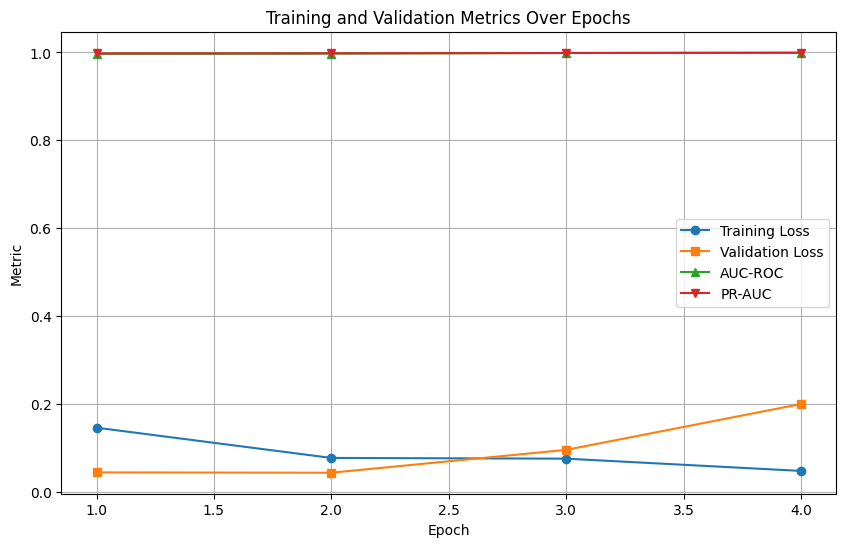

In [43]:
# Initialize model
num_frames = utils.NUM_FRAMES
model = GunshotModel.GunshotDetectionCNN(num_frames)

# Define optimizer and loss
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Calculate mean and std for normalization
means = []
stds = []
for spectrogram, _, _ in train_loader:
    means.append(spectrogram.mean())
    stds.append(spectrogram.std())
mean = th.tensor(means).mean()
std = th.tensor(stds).mean()

# Initialize training manager
training_manager = GunshotDetection.GunshotDetectionTrainer(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=10,
    mean=mean,
    std=std,
    eval_metric='f1',
    patience=3
)

# Train the model
best_threshold, best_score, last_failed_samples = training_manager.train()

In [108]:
def manual_evaluate_test(model, feature, threshold, frame_size=utils.NUM_FRAMES, sampling_rate=utils.SAMPLING_RATE, hop_length=utils.HOP_LENGTH, mean=None, std=None, step_size=None, filter_time_sec=0):
    """
    Manually evaluate the model on an audio feature, returning time positions where gunshots are detected.

    Parameters:
        model: The trained model.
        feature: The feature (e.g., spectrogram) to evaluate.
        threshold: The prediction threshold for gunshots.
        frame_size: Number of frames to use in each evaluation.
        sampling_rate: Audio sampling rate.
        hop_length: Hop length in samples for each frame.
        mean: Mean for normalization.
        std: Standard deviation for normalization.
        step_size: Step size for moving through frames (default: frame_size // 2).
        filter_time_sec: Time (in seconds) to filter out close consecutive predictions.
    
    Returns:
        List of tuples (minutes, seconds, output) where gunshots are detected along with the model's output.
    """
    if mean is None or std is None:
        raise ValueError("Mean and std must be provided for normalization.")

    mean = mean.to(device)
    std = std.to(device)
    model = model.to(device)
    model.eval()

    predictions = []

    feature = feature.to(device)
    feature = (feature - mean) / std

    num_frames = feature.shape[2]

    if step_size is None:
        step_size = 1

    total_iterations = 0

    with th.no_grad():
        for j in range(0, num_frames - frame_size + 1, step_size):
            total_iterations += 1
            start = j
            end = j + frame_size

            input_frame = feature[:, :, start:end].unsqueeze(0).float()
            output = model(input_frame).squeeze().item()
            predictions.append((output, start))

        print("Number of predictions", len(predictions))

        res = []
        for output, start in predictions:
            if output >= threshold:
                time_in_seconds = start * hop_length / sampling_rate
                minutes = int(time_in_seconds // 60)
                seconds = time_in_seconds % 60
                res.append((minutes, seconds, time_in_seconds, output))

    print(len(res))

    filtered_res = []
    last_detection_time = -float('inf')

    for minutes, seconds, time_in_seconds, output in res:
        if time_in_seconds - last_detection_time >= filter_time_sec:
            filtered_res.append((minutes, seconds, output))
            last_detection_time = time_in_seconds

    return filtered_res

In [110]:
spectrograms, sample_rates = utils.preprocess_audio(['/Users/borosabel/Documents/Uni/Thesis/PopMIR/50 Cent - Many Men (Wish Death) (Dirty Version).mp3'])

100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


In [111]:
predictions = manual_evaluate_test(model, spectrograms[0], threshold=best_threshold, mean=mean, std=std, step_size=1, filter_time_sec=1)

if(len(predictions) > 0):
    print(f"Current treshold is {best_threshold} \n")

    for minutes, seconds, output in predictions:
        print(f"Detected gunshot at {minutes}m {seconds:.2f}s with model output: {output:.4f}")
else:
    print("No predictions")

Number of predictions 25598
2192
Current treshold is 0.5 

Detected gunshot at 0m 2.79s with model output: 0.5851
Detected gunshot at 0m 5.58s with model output: 0.5480
Detected gunshot at 0m 8.38s with model output: 0.5358
Detected gunshot at 0m 10.51s with model output: 0.5147
Detected gunshot at 0m 11.52s with model output: 0.9789
Detected gunshot at 0m 12.53s with model output: 0.9997
Detected gunshot at 0m 13.54s with model output: 0.9995
Detected gunshot at 0m 33.76s with model output: 0.5824
Detected gunshot at 0m 38.65s with model output: 0.5282
Detected gunshot at 0m 43.04s with model output: 0.5475
Detected gunshot at 0m 44.05s with model output: 0.9880
Detected gunshot at 0m 45.06s with model output: 0.9979
Detected gunshot at 0m 46.07s with model output: 0.9570
Detected gunshot at 0m 47.08s with model output: 0.9985
Detected gunshot at 0m 48.09s with model output: 0.9065
Detected gunshot at 0m 49.10s with model output: 0.9821
Detected gunshot at 0m 50.11s with model output: